## Plot fasta nucleotide sequences

In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio.Blast.Applications import NcbiblastnCommandline 
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import pairwise2  
from Bio.pairwise2 import format_alignment 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from itertools import groupby

In [2]:
FASTA_PATH='../../fasta/'
TARGET_FILE='MN996532_2_RaTG13_complete_genome.fa'
ASM_PATH=FASTA_PATH+'asm_out/'
FASTA_LIST=['RaTG13_SL3_R1_megahit_default.fa', 'RaTG13_SL3_R1_megahit_k79.fa',\
            'RaTG13_SL3_R1_megahit_kstep10_nm.fa', 'RaTG13_SL3_R1_coronaspades_default.fa']
COV_NAME='RaTG13'
ASM_CODE='SL3_R1'
OUT_PATH=ASM_PATH+'comparison_plots/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [3]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
fasta_files = [os.path.join(ASM_PATH, x) for x in FASTA_LIST]

In [4]:
query_target = SeqIO.read(query_file, format="fasta")
query_target_seq=query_target.seq

fasta_targets = [SeqIO.read(x, format="fasta") for x in fasta_files]
assert len(fasta_targets)==len(FASTA_LIST)

In [5]:
fasta_seqs=[str(x.seq) for x in fasta_targets]
fasta_titles=[x.description for x in fasta_targets]

In [6]:
for s in fasta_seqs:
    assert len(s)==len(query_target_seq)

In [7]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r', title=''):
    print(f'>>plot_blocked_seq, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel('nucleotides', fontsize=10)
    plt.xticks(fontsize=10)
    plt.title(f'{title}', fontsize=12)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

In [8]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

In [9]:
seq_arrays=[np.array(list(x)) for x in fasta_seqs]
ord_arrays=[]
for seqa in seq_arrays:
    ta=ord_v(seqa)
    #change '-' char value to zero for background colour
    ta[ta == 45] = 0
    ord_arrays.append(ta)

In [10]:
#add an empty array in between each for plotting
spacer_array=np.zeros(len(query_target_seq))
spaced_seqs=[]
for a in ord_arrays:
    spaced_seqs.append(a)
    spaced_seqs.append(spacer_array)

In [34]:
#create subdomain markers 3 NN wide for plotting. NN locations identified at NCBI
subdomain_boundaris=[265,266,267, 21562,21563,21564, 22548,22549,22550, \
                     23310,23311,23312, 23603,23604,23605, 25359,25360,25361, \
                     25380,25381,25382, 26207,26208,26209, 26510,26511,26512, \
                     27178,27179,27180, 28261,28262,28263, 29520,29521,29522]
subdomain_array=np.zeros(len(query_target_seq))
for b in subdomain_boundaris:
    subdomain_array[b]= 84

In [35]:
twod_borders=np.stack([subdomain_array, subdomain_array], axis=0)
spacer_twod=np.stack([spacer_array, spacer_array], axis=0)
twod_borders=np.stack([twod_borders, spacer_twod], axis=0)

In [36]:
twod_borders=twod_borders.reshape(4, len(query_target_seq))
twod_borders.shape

(4, 29855)

In [37]:
twod_borders_repeated = np.repeat(twod_borders, repeats=500, axis=0)
twod_borders_repeated.shape

(2000, 29855)

In [38]:
#convert to 2D so can plot
#stacked=np.stack(ord_arrays, axis=0)
stacked=np.stack(spaced_seqs, axis=0)

In [39]:
np.unique(stacked[0])

array([ 0., 65., 67., 71., 84.])

In [40]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
stacked_repeated.shape

(4000, 29855)

In [41]:
twod_borders_on_stack=np.vstack((twod_borders_repeated, stacked_repeated))
twod_borders_on_stack.shape

(6000, 29855)

>>plot_blocked_seq, stack_arr: (6000, 29855)


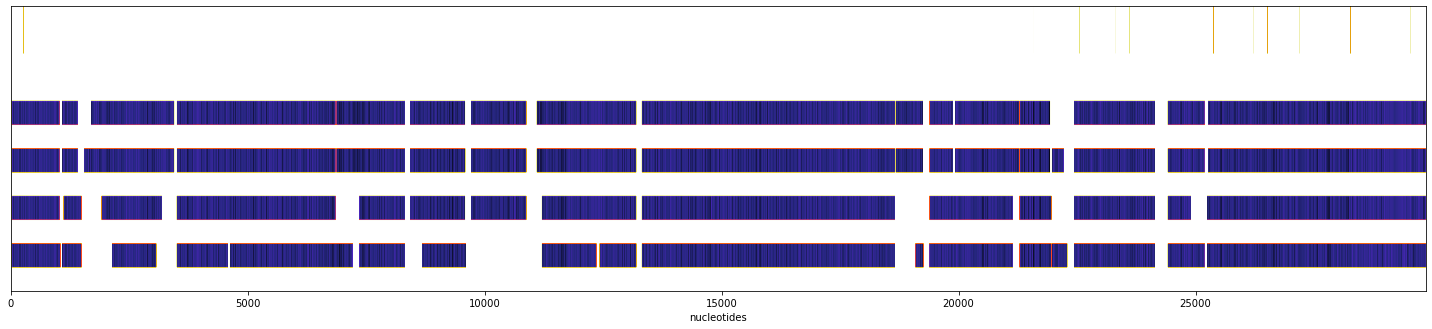

In [42]:

#plot_title=', '.join(x for x in FASTA_LIST)
plot_title=''
plot_blocked_seq(twod_borders_on_stack, name=OUT_PATH+f'{len(FASTA_LIST)}_{COV_NAME}_{ASM_CODE}_stiched_asm_seqs.png', title=plot_title)

Find empty columns (0 value)

In [20]:
missing_nns = np.argwhere(np.all(stacked[..., :] == 0, axis=0)).tolist()

In [21]:
len(missing_nns)

1303

In [22]:
missing_nns = [item for sublist in missing_nns for item in sublist]

In [23]:
spike_seq_missing = [i for i in missing_nns if int(i) >= 21563 and int(i)<=25384 ]

In [24]:
len(spike_seq_missing)

464

In [25]:
def group(L):
    '''after https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list'''''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [26]:
print (list(group(spike_seq_missing)))

[(21953, 21957), (22288, 22427), (24134, 24404), (25185, 25232)]


In [27]:
grouped_missing= list(group(missing_nns))

In [28]:
grouped_missing

[(0, 13),
 (1045, 1073),
 (1488, 1536),
 (3445, 3495),
 (8313, 8419),
 (9600, 9706),
 (10875, 11091),
 (13196, 13307),
 (18653, 18664),
 (19253, 19375),
 (21265, 21277),
 (21953, 21957),
 (22288, 22427),
 (24134, 24404),
 (25185, 25232),
 (29850, 29854)]

In [29]:
deltas=[]
for t in grouped_missing:
    deltas.append(t[1]-t[0])

In [30]:
len(deltas),deltas

(16, [13, 28, 48, 50, 106, 106, 216, 111, 11, 122, 12, 4, 139, 270, 47, 4])

<BarContainer object of 16 artists>

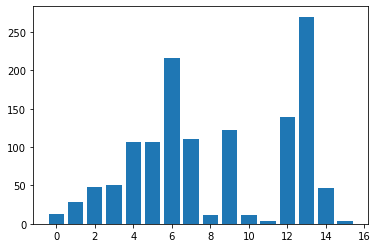

In [31]:
plt.bar(list(range(len(deltas))), deltas)

In [32]:
pct_missing = (len(missing_nns)/len(query_target_seq))%100

In [33]:
print(f'{pct_missing} from any assemby method')

0.043644280690001674 from any assemby method
